# **Libraries**

In [ ]:
import cv2
import numpy as np
import math
from google.colab.patches import cv2_imshow
from scipy.fftpack import dct
from scipy.fftpack import idct
from skimage.util import random_noise

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Reading Images**

Original Image


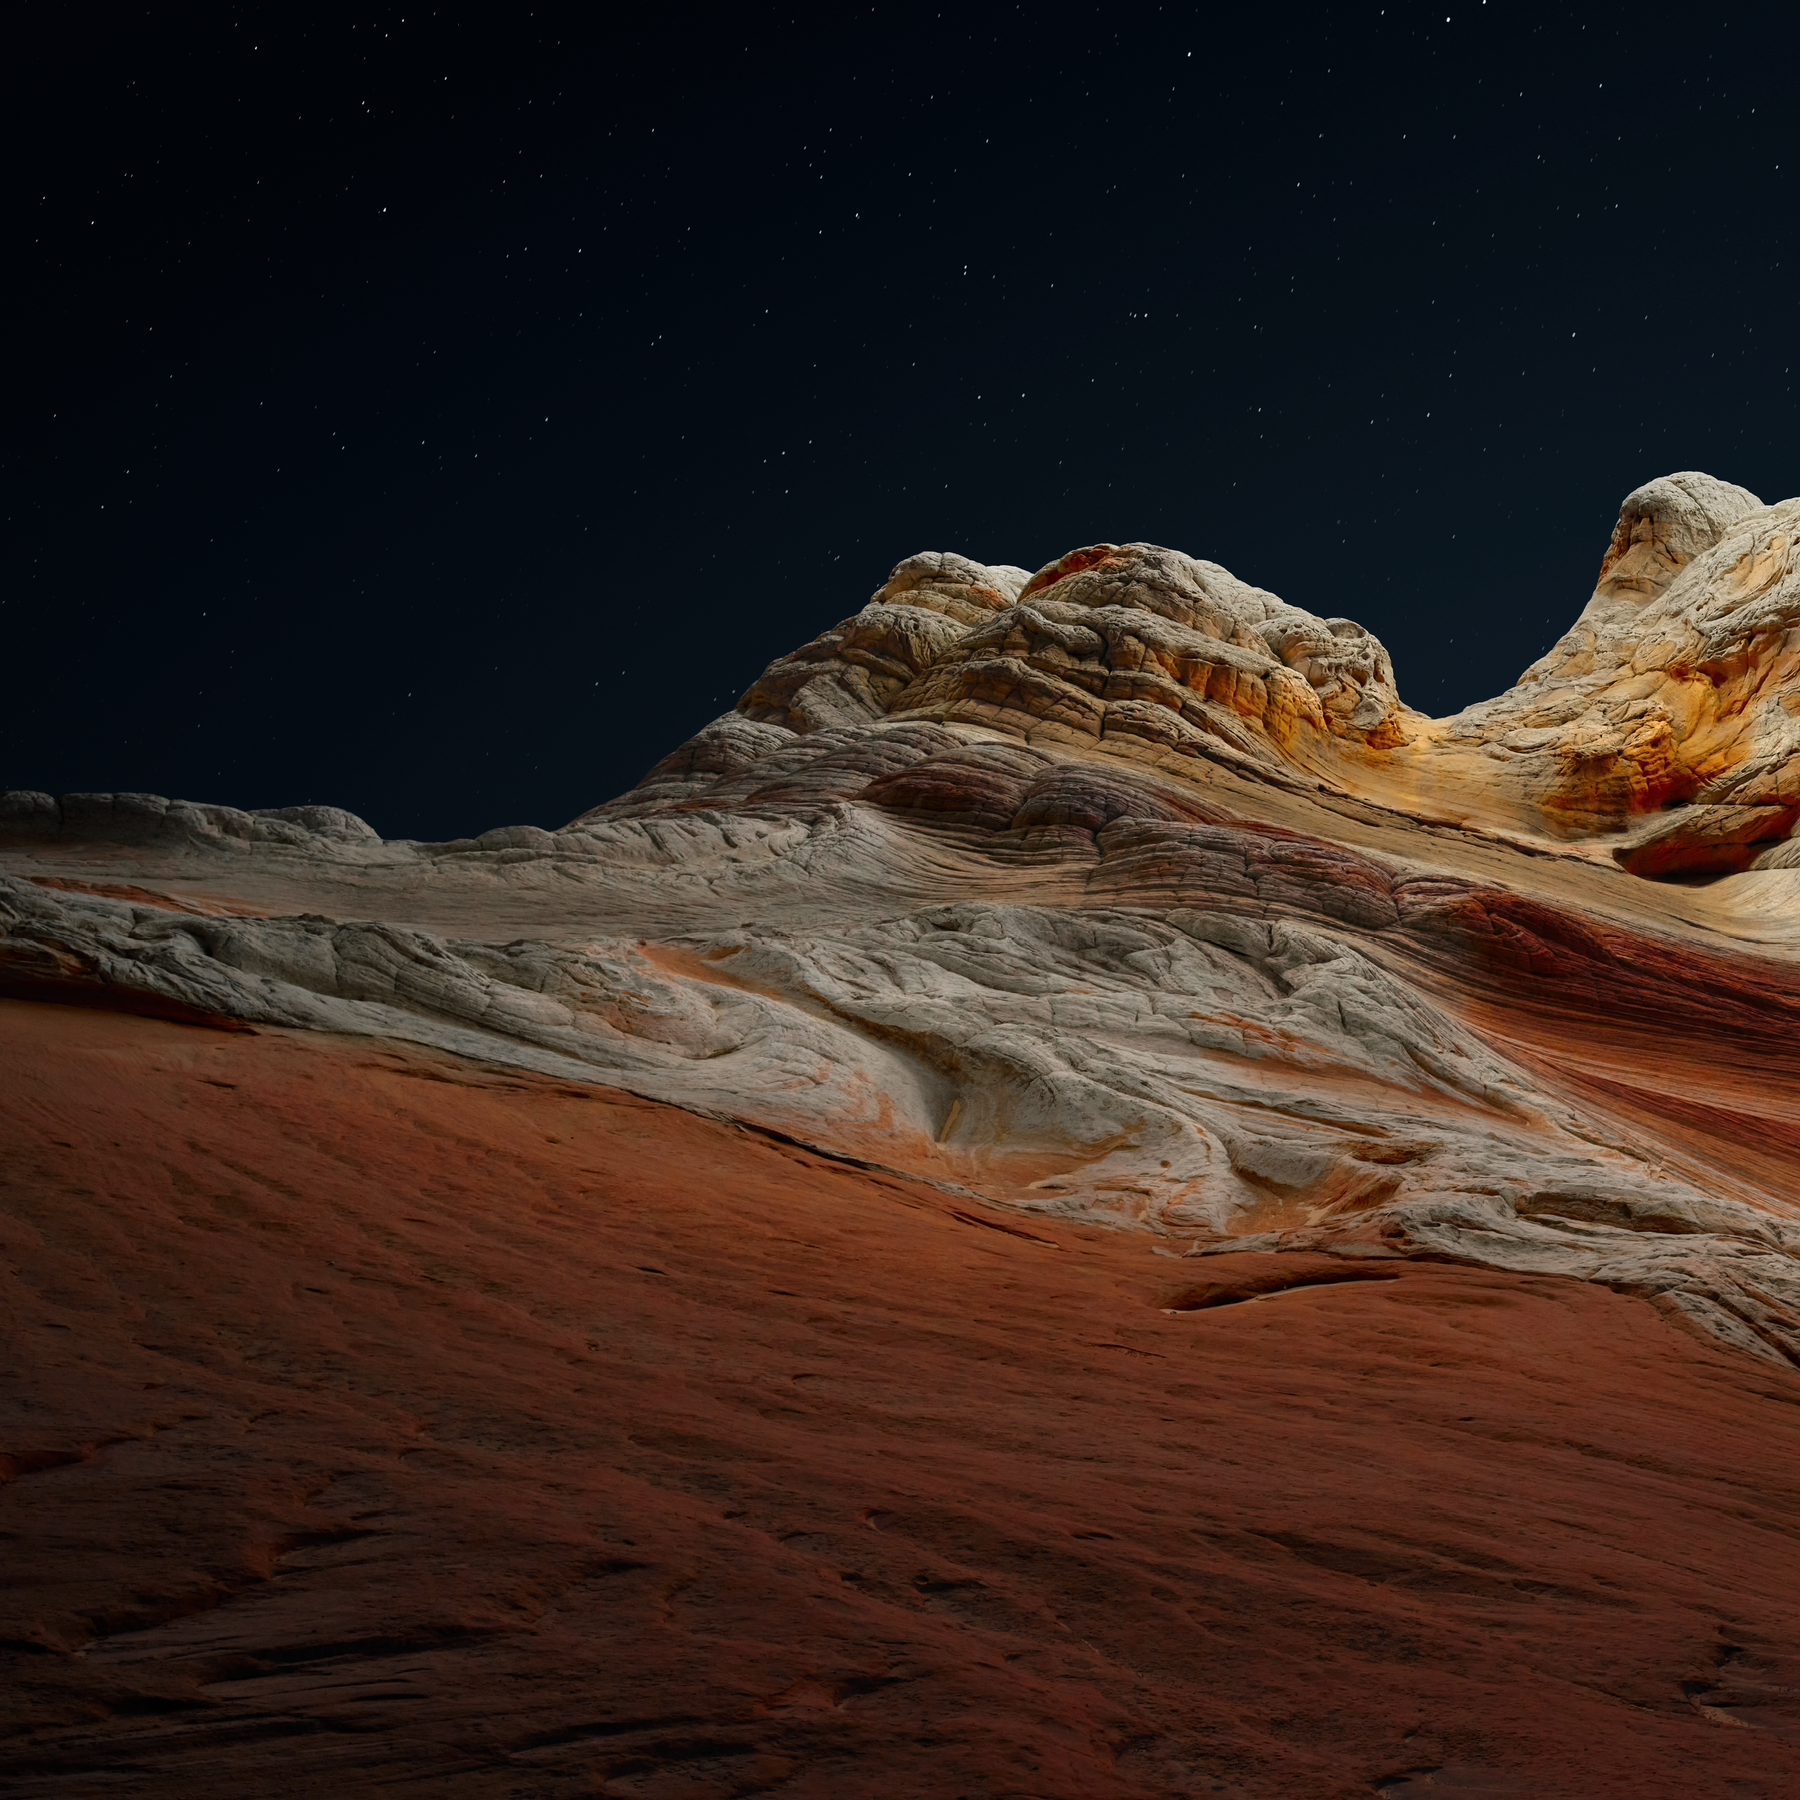

Watermark image


In [ ]:
image_path="/content/drive/MyDrive/SFLabimage/cover.jpg"
watermark_path="/content/drive/MyDrive/SFLabimage/iitbbs_logo.jpeg"
img_original=cv2.imread(image_path)
img_watermark=cv2.imread(watermark_path)
print("Original Image")
cv2_imshow(img_original)
print("Watermark image")
cv2_imshow(img_watermark)

## **Resizeing Images**

**resize watermark and convert into grey scale**

In [ ]:
def watermark_image_resize(image_path,size):
    img=cv2.imread(image_path)
    img=cv2.resize(img,(size,size))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    image_array=np.array(img,dtype=float).reshape((size, size))
    cv2_imshow(img)
    return img,image_array

In [ ]:
def orignal_image_resize(image_path,size):
    img=cv2.imread(image_path)
    img=cv2.resize(img,(size,size))
    image_array=np.array(img,dtype=float).reshape((size, size,3))
    cv2_imshow(img)
    return img,image_array

Resized original image


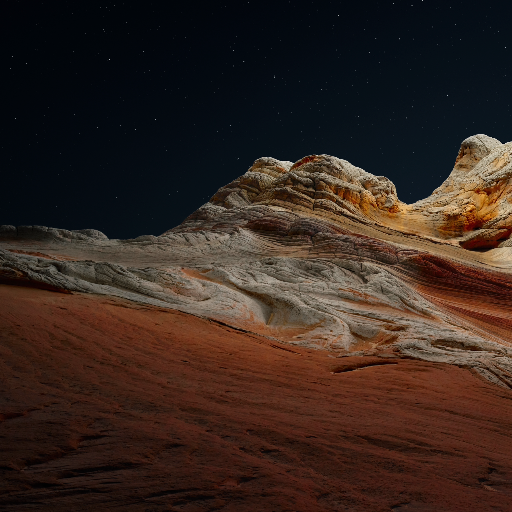

Resized Watermark image


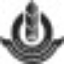

In [ ]:
print("Resized original image")
image_resize,image_resize_array=orignal_image_resize(image_path,512)

print("Resized Watermark image")
watermark_resize,watermark_resize_array=watermark_image_resize(watermark_path,64)   


# **Apply DCT**

In [ ]:
def apply_dct(image_array):
    size = image_array[0].__len__()
    all_subdct = np.empty((size, size))
    for i in range (0, size, 8):
        for j in range (0, size, 8):
            subpixels = image_array[i:i+8, j:j+8]
            subdct = dct(dct(subpixels.T, norm="ortho").T, norm="ortho")
            all_subdct[i:i+8, j:j+8] = subdct
    return all_subdct

**Applay dct on 0th channel of image**

In [ ]:
watermark_resize_array=watermark_resize_array/255
b=apply_dct(image_resize_array[:,:,0])

In [ ]:
def embed_watermark(watermark_array, orig_image):
    orig_image_dummy = orig_image
    watermark_array_size = watermark_array[0].__len__()
    watermark_flat = watermark_array.ravel()
    ind = 0   
    for x in range (0, orig_image.__len__(), 8):
        for y in range (0, orig_image.__len__(), 8):
            if ind < watermark_flat.__len__():
                subdct = orig_image[x:x+8, y:y+8]
                subdct [7][7] = watermark_flat[ind]
                orig_image_dummy[x:x+8, y:y+8] = subdct
                ind += 1 
    return orig_image_dummy

In [ ]:
def inverse_dct(all_subdct):
    size = all_subdct[0].__len__()
    all_subidct = np.empty((size, size))
    for i in range (0, size, 8):
        for j in range (0, size, 8):
            subidct = idct(idct(all_subdct[i:i+8, j:j+8].T, norm="ortho").T, norm="ortho")
            all_subidct[i:i+8, j:j+8] = subidct
    return all_subidct

**Embed water mark on converted dct of 0th channel of image**

After applying Inverse dct


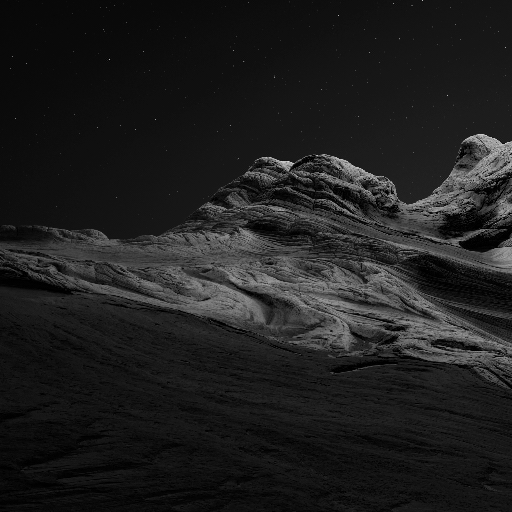

In [ ]:
b_array=embed_watermark(watermark_resize_array,b)
b_watermarked_image=inverse_dct(b_array)
print("After applying Inverse dct")
cv2_imshow(b_watermarked_image)

**append all 3 channel make water embed image**

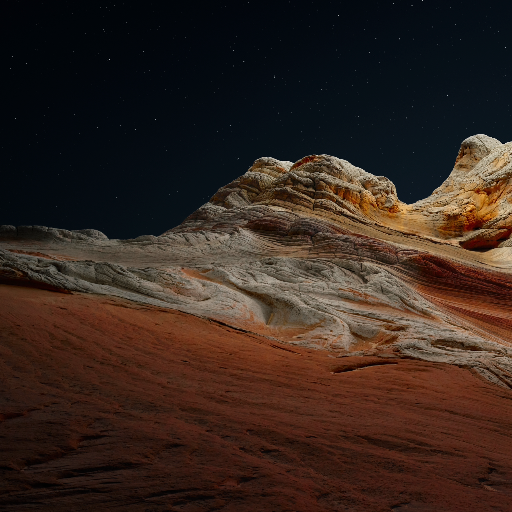

In [ ]:
image_wm = np.zeros((512,512,3))
image_wm[:,:,0] = b_watermarked_image
image_wm[:,:,1] = image_resize_array[:,:,1]
image_wm[:,:,2] = image_resize_array[:,:,2]
cv2_imshow(image_wm)

In [ ]:
cv2.imwrite("/content/drive/MyDrive/watermarkedimg.jpg",image_wm)

True

# **PSNR Value**

In [ ]:
def PSNR(original, secretImage): 
    mse = np.mean((secretImage-original) ** 2) 
    if(mse == 0):  
        return 100
    max_pixel = 255.0
    #print(mse)
    psnr = 20 * np.log10(max_pixel/np.sqrt(mse)) 
    return psnr 

**PSNR value of water marked image and original image**

In [ ]:
PSNR(image_wm, image_resize)

54.6393534838787

# **Decoding Watermark**



In [ ]:
def get_watermark(dct_watermarked_image, watermark_size):
    subwatermarks = []
    for x in range (0, dct_watermarked_image.__len__(), 8):
        for y in range (0, dct_watermarked_image.__len__(), 8):
            islice = dct_watermarked_image[x:x+8, y:y+8]
            subwatermarks.append(islice[7][7])         
    watermark = np.array(subwatermarks).reshape(watermark_size, watermark_size)*255
    watermark =  np.uint8(watermark)
    return watermark

**after recovering watermark from emedded image and calculate psnr value**

Recovered watermark Image


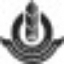

watermark image


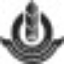

PSNR Value of Recovered watermark image  w.r.t watermark image


51.4349837539486

In [ ]:
b=apply_dct(b_watermarked_image)
water_recov=get_watermark(b,64)
print("Recovered watermark Image")
cv2_imshow(water_recov)
print("watermark image")
cv2_imshow(watermark_resize)
print("PSNR Value of Recovered watermark image  w.r.t watermark image")
PSNR(watermark_resize,water_recov)

### **Attacks (Signal Processing And Geaometric Attacks)**

In [ ]:
def noisy(noise_typ,image):
    if noise_typ == "gauss":
        row,col,ch= image.shape
        mean = 0
        var = 0.001
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        return noisy
    elif noise_typ == "s&p":
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = 0.01
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
                for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
                for i in image.shape]
        out[coords] = 0
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ =="speckle":
        row,col,ch = image.shape
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)        
        noisy = image + image * gauss
        return noisy
    elif noise_typ == "rotate90" :
        angle = 90
        scale = 1.0
        w = image.shape[1]
        h = image.shape[0]
        rangle = np.deg2rad(angle)  # angle in radians
        nw = (abs(np.sin(rangle) * h) + abs(np.cos(rangle) * w)) * scale
        nh = (abs(np.cos(rangle) * h) + abs(np.sin(rangle) * w)) * scale
        rot_mat = cv2.getRotationMatrix2D((nw * 0.5, nh * 0.5), angle, scale)
        rot_move = np.dot(rot_mat, np.array(
            [(nw - w) * 0.5, (nh - h) * 0.5, 0]))
        rot_mat[0, 2] += rot_move[0]
        rot_mat[1, 2] += rot_move[1]
        noisy=cv2.warpAffine(image, rot_mat, (int(math.ceil(nw)), int(math.ceil(nh))), flags=cv2.INTER_LANCZOS4)
        return noisy
    elif noise_typ=="chop30":
        img = image.copy()
        w, h = img.shape[:2]
        noisy=img[int(w * 0.3):, :]
        return noisy


**rotation 90 attack**

image with rotate 90 


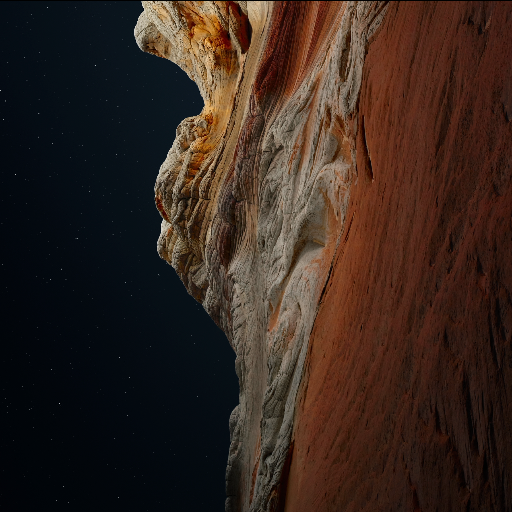

recovered watermark image with noise


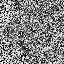

PSNR value noisy watermark image  w.r.t watermark image 


27.911807442950515

In [ ]:
noise_img=noisy("rotate90",image_wm)
print("image with rotate 90 ")
cv2_imshow(noise_img)
water_recov=get_watermark(apply_dct(noise_img[:,:,0]),64)
print("recovered watermark image with noise")
cv2_imshow(water_recov)
print("PSNR value noisy watermark image  w.r.t watermark image ")
PSNR(watermark_resize,water_recov)

**Pepper and saLT attack**

image with Pepper and Salt Noise 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


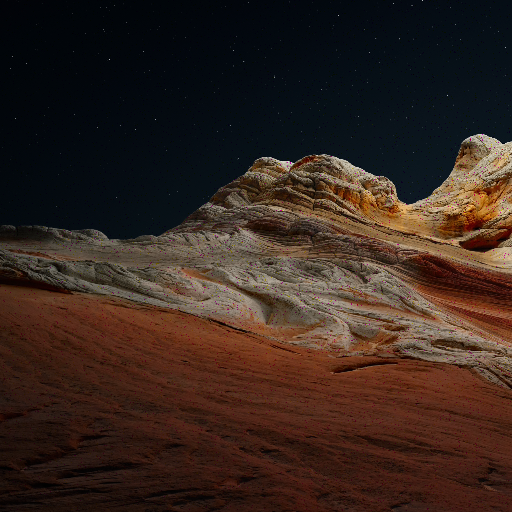

recovered watermark image with noise


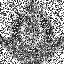

PSNR value noisy watermark image  w.r.t watermark image 


29.998685945614767

In [ ]:
noise_img=noisy("s&p",image_wm)
print("image with Pepper and Salt Noise ")
cv2_imshow(noise_img)
water_recov=get_watermark(apply_dct(noise_img[:,:,0]),64)
print("recovered watermark image with noise")
cv2_imshow(water_recov)
print("PSNR value noisy watermark image  w.r.t watermark image ")
PSNR(watermark_resize,water_recov)

**Gaussian attack**

image with Gaussian Noise


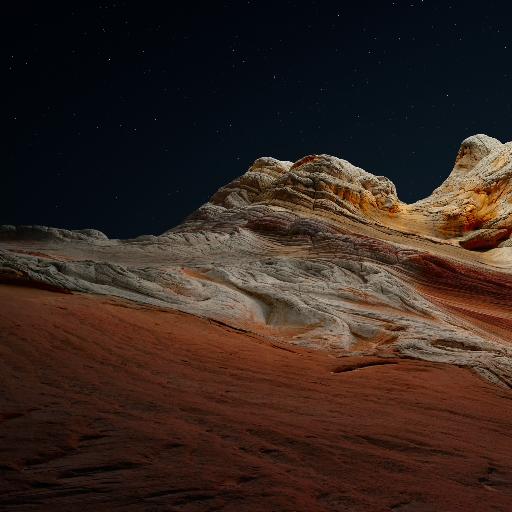

recovered watermark image with noise


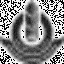

PSNR value noisy watermark image  w.r.t watermark image 


31.145856260819144

In [ ]:
noise_img=noisy("gauss",image_wm)
water_recov=get_watermark(apply_dct(noise_img[:,:,0]),64)
print("image with Gaussian Noise")
cv2_imshow(noise_img)
print("recovered watermark image with noise")
cv2_imshow(water_recov)
print("PSNR value noisy watermark image  w.r.t watermark image ")
PSNR(watermark_resize,water_recov)

**speckle attack**

image with specle Noise


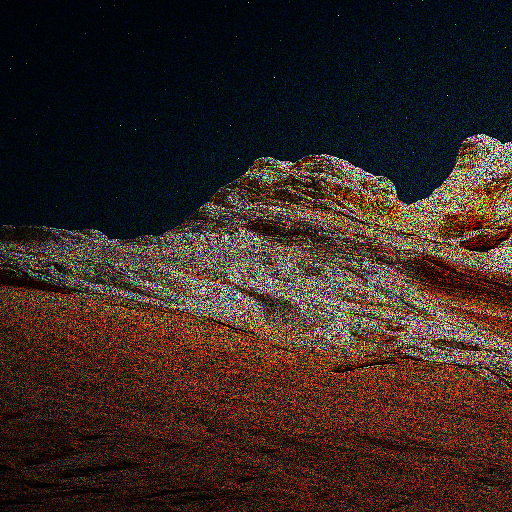

recovered watermark image with noise


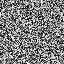

PSNR value noisy watermark image  w.r.t watermark image 


27.989685436245995

In [ ]:
noise_img=noisy("speckle",image_wm)
water_recov=get_watermark(apply_dct(noise_img[:,:,0]),64)
print("image with specle Noise")
cv2_imshow(noise_img)
print("recovered watermark image with noise")
cv2_imshow(water_recov)
print("PSNR value noisy watermark image  w.r.t watermark image ")
PSNR(watermark_resize,water_recov)